# Baggage Computer Vision

This notebook contains all the code needed to train the computer vision model for this project.

## Import libraries

First, we'll need to import the libraries required for the project. These include standard libraries for data/image manipulation, file reading, and ML.

In [1]:
from PIL import Image
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# In order to use GPU memory cautiously,we will set tensorflow option to grow GPU memory allocation when required.
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Xray data

The primary sources of data we could use are the PIDray and SIXray datasets. These are available to download from the following links:

- **PIDray**: https://paperswithcode.com/dataset/pidray
- **SIXray**: https://paperswithcode.com/dataset/sixray

These datasets include the images themselves as well as an annotation file with data about the picture, such as the illegal object within the image (gun, knife, etc) and where it is located.

Because of the size of these datasets, we're just going to use the PIDray training dataset for this excersise.

## Importing the annotations data

The first thing we'll need to do is take a look at the images themselves to get a sense of the task ahead. We'll load the first image in the file:

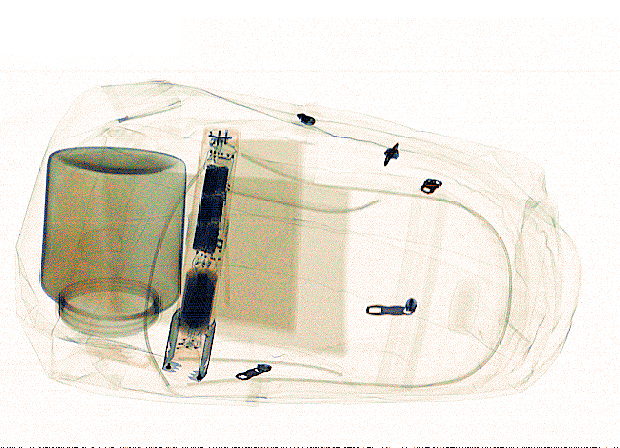

In [2]:
img_path = "Data/Images/"

Image.open(img_path + os.listdir(img_path)[0])

Now we can read in the images, we also need to read in the accompanying dataframe with the annotations.

In [3]:
from pandas.io.json import json_normalize

# read in the json annotations file
with open('Data/xray_train.json') as json_data:
    data = json.load(json_data)
    
annotations_df = pd.DataFrame(data['annotations'])
annotations_df.head()

,id,image_id,category_id,segmentation,bbox,iscrowd,area
0,0,0,1,"[[202.8904109589041, 127.08219178082192, 176.8...","[160.4246575342466, 127.08219178082192, 80.821...",0,1.0
1,1,1,1,"[[323.027397260274, 202.4246575342466, 343.575...","[323.027397260274, 93.52054794520548, 172.6027...",0,1.0
2,2,2,1,"[[93.02739726027397, 328.45205479452056, 110.1...","[90.2876712328767, 320.9178082191781, 196.5753...",0,1.0
3,3,3,1,"[[72.06849315068493, 182.56164383561645, 66.58...","[66.58904109589042, 182.56164383561645, 319.17...",0,1.0
4,4,4,1,"[[114.1232876712329, 185.3013698630137, 118.91...","[114.1232876712329, 162.013698630137, 167.8082...",0,1.0


The annotations dataframe has the following columns:

- *id*: this is simply the index of the image
- *image_id*: this is the unique id for the image
- *category_id*: a numeric value indicating what illegal item is in the picture
    1. Baton
    2. Bullet
    3. Gun
    4. Hammer
    5. Handcuffs
    6. Knife
    7. Lighter
    8. Pliers
    9. Powerbank
    10. Scissors
    11. Sprayer
    12. Wrench
- *segmentation*: a list of coordinates for the suitcase
- *bbox*: coodinates for a 'boundary box' around the illegal item


## Join up the images and dataframe

The next step is to link the dataframe with the image by adding columns for the category and image names.

In [4]:
# create column of 
annotations_df['image_name'] = ['xray_' + str(x).zfill(5) + '.png' for x in annotations_df['image_id']]

# create column of category names using dictionary
category_dict = {1:'Baton', 2:'Bullet', 3:'Gun', 4:'Hammer', 5:'Handcuffs', 6:'Knife', 7:'Lighter', 8:'Pliers', 9:'Powerbank', 10:'Scissors', 11:'Sprayer', 12: 'Wrench'}
def matchDict(s):
    for key, value in category_dict.items():
        if key == s:
            return value

annotations_df['category_name'] = annotations_df['category_id'].apply(matchDict)
annotations_df.head()

,id,image_id,category_id,segmentation,bbox,iscrowd,area,image_name,category_name
0,0,0,1,"[[202.8904109589041, 127.08219178082192, 176.8...","[160.4246575342466, 127.08219178082192, 80.821...",0,1.0,xray_00000.png,Baton
1,1,1,1,"[[323.027397260274, 202.4246575342466, 343.575...","[323.027397260274, 93.52054794520548, 172.6027...",0,1.0,xray_00001.png,Baton
2,2,2,1,"[[93.02739726027397, 328.45205479452056, 110.1...","[90.2876712328767, 320.9178082191781, 196.5753...",0,1.0,xray_00002.png,Baton
3,3,3,1,"[[72.06849315068493, 182.56164383561645, 66.58...","[66.58904109589042, 182.56164383561645, 319.17...",0,1.0,xray_00003.png,Baton
4,4,4,1,"[[114.1232876712329, 185.3013698630137, 118.91...","[114.1232876712329, 162.013698630137, 167.8082...",0,1.0,xray_00004.png,Baton


With the images mapped to the dataframe, we can take the first image and present the object with the name and boundary box.

In [23]:
import torchvision.io as tfi


img = tfi.read_file(img_path + annotations_df.loc[0, 'image_name'])
tensor = tfi.decode_image(img)
bbox = tf.convert_to_tensor(annotations_df.loc[0, 'bbox'])

#img = np.array(img)
# Convert the PIL image to Tensor
#img_to_tensor = tf.convert_to_tensor(img)
# print the converted Torch tensor
colors = np.array([1.0])

tf.image.draw_bounding_boxes(
    img, bbox, colors
)

InvalidArgumentError: The rank of the images should be 4 [Op:DrawBoundingBoxesV2]

## Augmenting the images

Now that we have the data and the images loaded, we can now augment our images so that the size is standardised and create some altered images to train our model.

Our images are varied in size, however our model will need a standardised input so we'll need to resize our images.

In [26]:
tensor.shape

torch.Size([3, 448, 620])

## Build basic model

The model we'll use is a TensorFlow convolutional neural network. First we'll build the model that we'll train. The model architecture follows the following specification:

1. An input layer of size 448x448
2. A convolutional layer with 9 filters
3. A flattening layer
4. An output layer of size 12, as there are 12 classes

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=9, kernel_size=(5,5), input_shape=(448,448,1),activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(12)
])

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['acc'])

model.summary()